In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define possible moves: up, down, left, right
MOVES = [(0,1), (0,-1), (1,0), (-1,0)]

def get_neighbors(pos):
    return [(pos[0]+dx, pos[1]+dy) for dx, dy in MOVES]

def is_valid_move(pos, path):
    return pos not in path

def smc_saw(num_particles, max_length):
    particles = [([(0,0)], 1.0) for _ in range(num_particles)]
    mu_estimates = []

    for length in range(1, max_length + 1):
        new_particles = []
        total_weight = 0.0

        for path, weight in particles:
            current_pos = path[-1]
            neighbors = get_neighbors(current_pos)
            valid_moves = [move for move in neighbors if is_valid_move(move, path)]

            num_valid = len(valid_moves)
            if num_valid == 0:
                continue

            move = random.choice(valid_moves)
            new_path = path + [move]
            new_weight = weight * num_valid

            new_particles.append((new_path, new_weight))
            total_weight += new_weight

        if not new_particles:
            break

        mu = total_weight / sum(w for _, w in particles)
        mu_estimates.append(mu)
        particles = new_particles

    return mu_estimates

# Example usage
mu_values = smc_saw(num_particles=1000, max_length=500)
print(mu_values)


[4.0, 3.0, 3.0, 2.783, 2.8393819619116063, 2.754365983295368, 2.7899379738111647, 2.707277308433378, 2.772528194459652, 2.707067116876962, 2.7322202284563875, 2.6978062903962132, 2.744353402208764, 2.6816211023703818, 2.715855181628069, 2.685771985658534, 2.6966053889036368, 2.6853423802896454, 2.684990629815005, 2.6964056655201296, 2.677199898966008, 2.720924754707353, 2.7279706405999833, 2.6816752869582774, 2.668910968108842, 2.6778210013217234, 2.67165772569822, 2.678507098848851, 2.6426511024414596, 2.679282910608157, 2.6535001362122554, 2.6637116952815814, 2.6979056220040905, 2.6740394803609933, 2.696519699258718, 2.683751058640382, 2.6595131240894045, 2.676233478909805, 2.717431803334663, 2.7234676080701097, 2.7250392803666226, 2.6970899216996185, 2.695451288993436, 2.7443810225583394, 2.6364577701103338, 2.5804626394774597, 2.6156506459765887, 2.6401360803245746, 2.6799215742418894, 2.787089234007736, 2.5754610397277475, 2.6345096974919135, 2.4685933559678133, 2.7435404082772794

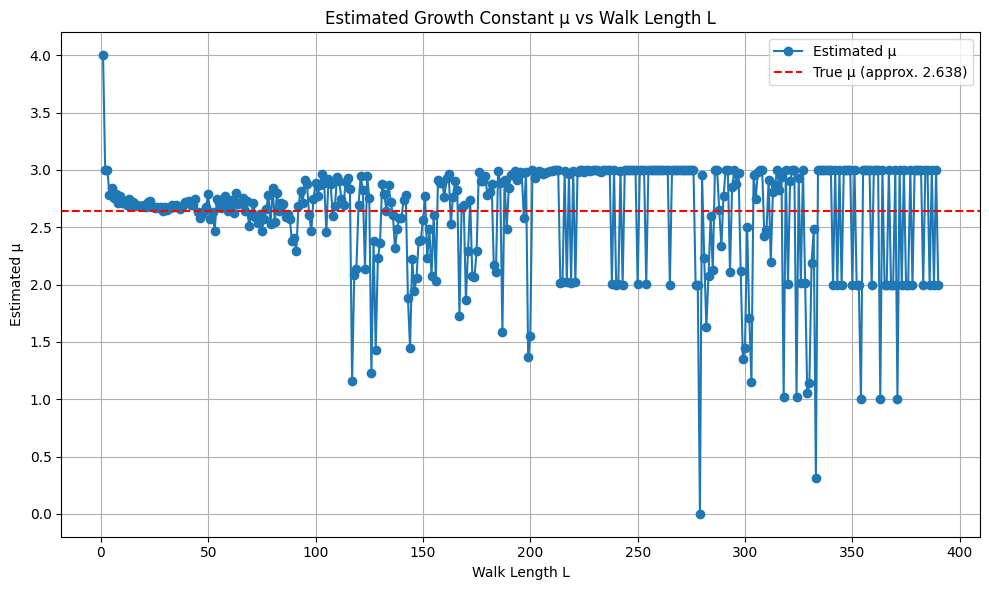

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mu_values) + 1), mu_values, marker='o', label='Estimated μ')
plt.axhline(y=2.638, color='red', linestyle='--', label='True μ (approx. 2.638)')
plt.title("Estimated Growth Constant μ vs Walk Length L")
plt.xlabel("Walk Length L")
plt.ylabel("Estimated μ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SMC with Importance sampling, resampling, and linear regression

100%|██████████| 1000/1000 [00:52<00:00, 18.93it/s]

Final estimate of μ: 2.6400


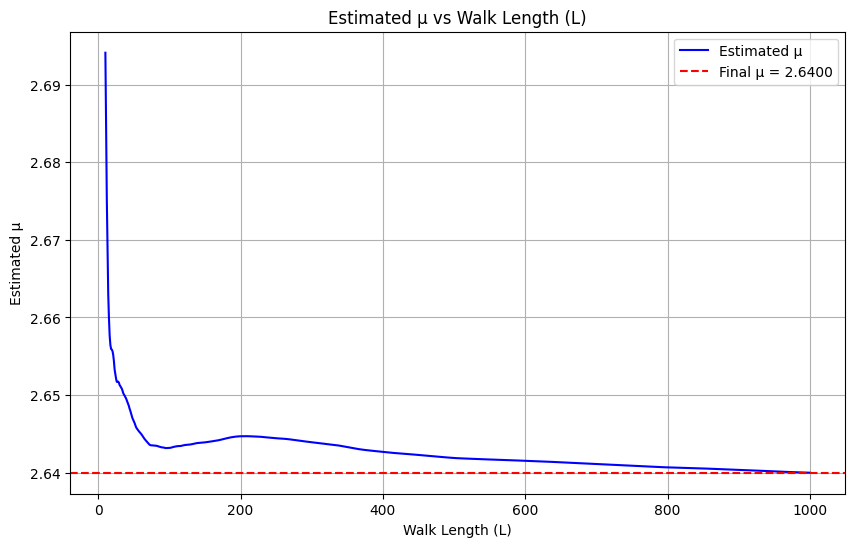

In [9]:
import random
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt

def estimate_mu(N, max_L):
    # Initialize N walks at L=0 (single point)
    walks = [[(0, 0)] for _ in range(N)]
    log_c = 0.0  # log(c_0) = 0 since c_0=1

    # Lists for regression data: y = (log c_L)/L, x1 = 1/L, x2 = (log L)/L
    y_list, x1_list, x2_list = [], [], []
    mu_estimates = []  # To store intermediate mu estimates
    L_values = []      # To store corresponding L values

    for step in tqdm(range(max_L)):
        new_walks, weights = [], []
        current_L = step + 1  # Current L after extension

        # Extend each walk from L to L+1
        for path in walks:
            x, y = path[-1]
            neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
            valid = [n for n in neighbors if n not in path]
            m = len(valid)

            if m > 0:
                new_path = path + [random.choice(valid)]
                weight = m
            else:
                new_path = path  # Trapped
                weight = 0

            new_walks.append(new_path)
            weights.append(weight)

        # Calculate ratio c_{L+1}/c_L (average weight)
        r_L = np.mean(weights)
        if r_L <= 0:
            break  # All walks trapped

        log_c += np.log(r_L)

        # Store regression data
        y = log_c / current_L
        x1 = 1 / current_L
        x2 = np.log(current_L) / current_L
        y_list.append(y)
        x1_list.append(x1)
        x2_list.append(x2)

        # Resample walks based on weights
        total_weight = sum(weights)
        if total_weight > 0:
            probs = [w / total_weight for w in weights]
            indices = np.random.choice(len(new_walks), size=N, p=probs)
            walks = [new_walks[i] for i in indices]
        else:
            break  # All walks trapped

        # Perform regression up to current_L to estimate mu
        if current_L >= 10:  # Start estimating mu after some steps
            X = np.column_stack((x1_list, x2_list, np.ones_like(x1_list)))
            model = sm.OLS(y_list, X)
            results = model.fit()
            log_mu = results.params[2]  # Intercept term is log(mu)
            mu_estimates.append(np.exp(log_mu))
            L_values.append(current_L)

    # Final regression to estimate mu
    X = np.column_stack((x1_list, x2_list, np.ones_like(x1_list)))
    model = sm.OLS(y_list, X)
    results = model.fit()
    log_mu = results.params[2]  # Intercept term is log(mu)
    mu_final = np.exp(log_mu)

    return mu_final, L_values, mu_estimates

# Parameters
N = 1000
max_L = 1000

# Estimate mu and get intermediate values
mu_final, L_values, mu_estimates = estimate_mu(N, max_L)
print(f"Final estimate of μ: {mu_final:.4f}")

# Plot mu estimates vs L
plt.figure(figsize=(10, 6))
plt.plot(L_values, mu_estimates, 'b-', label='Estimated μ')
plt.axhline(y=mu_final, color='r', linestyle='--', label=f'Final μ = {mu_final:.4f}')
plt.xlabel('Walk Length (L)')
plt.ylabel('Estimated μ')
plt.title('Estimated μ vs Walk Length (L)')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 117.55it/s]

Final estimate of μ: 2.6530

Values of c_L:
L = 1: c_L = 4.0000e+00
L = 2: c_L = 1.2000e+01
L = 3: c_L = 3.6000e+01
L = 4: c_L = 1.0048e+02
L = 5: c_L = 2.8405e+02
L = 6: c_L = 7.8482e+02
L = 7: c_L = 2.1708e+03
L = 8: c_L = 5.9893e+03
L = 9: c_L = 1.6423e+04
L = 10: c_L = 4.4702e+04
L = 11: c_L = 1.2284e+05
L = 12: c_L = 3.3094e+05
L = 13: c_L = 8.9121e+05
L = 14: c_L = 2.4107e+06
L = 15: c_L = 6.5162e+06
L = 16: c_L = 1.7489e+07
L = 17: c_L = 4.7064e+07
L = 18: c_L = 1.2665e+08
L = 19: c_L = 3.4854e+08
L = 20: c_L = 9.5500e+08
L = 21: c_L = 2.5833e+09
L = 22: c_L = 7.0032e+09
L = 23: c_L = 1.8986e+10
L = 24: c_L = 5.1167e+10
L = 25: c_L = 1.3651e+11
L = 26: c_L = 3.6162e+11
L = 27: c_L = 9.7421e+11
L = 28: c_L = 2.6440e+12
L = 29: c_L = 7.0648e+12
L = 30: c_L = 1.9011e+13
L = 31: c_L = 5.0627e+13
L = 32: c_L = 1.3325e+14
L = 33: c_L = 3.5578e+14
L = 34: c_L = 9.4602e+14
L = 35: c_L = 2.5410e+15
L = 36: c_L = 6.8378e+15
L = 37: c_L = 1.8168e+16
L = 38: c_L = 4.8654e+16
L = 39: c_L = 1

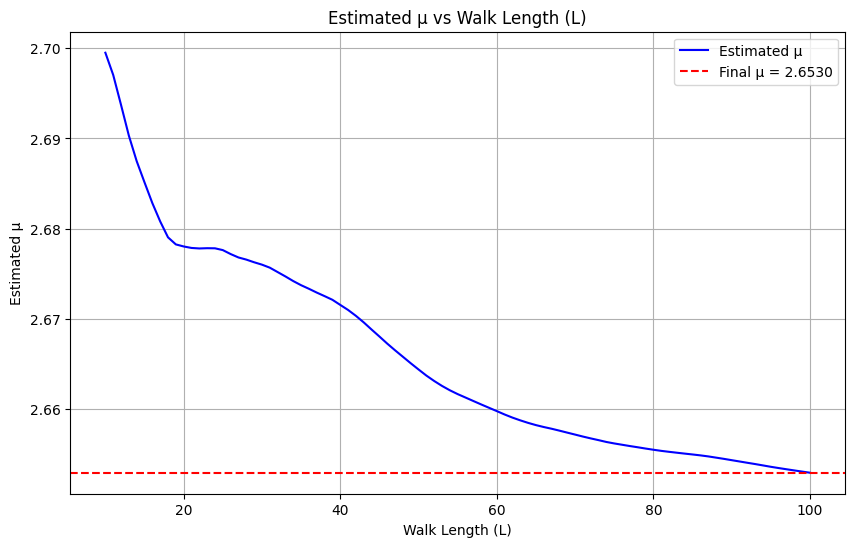

In [10]:
import random
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt

def estimate_mu(N, max_L):
    # Initialize N walks at L=0 (single point)
    walks = [[(0, 0)] for _ in range(N)]
    log_c = 0.0  # log(c_0) = 0 since c_0=1
    c_L = 1.0    # c_0 = 1

    # Lists for regression data: y = (log c_L)/L, x1 = 1/L, x2 = (log L)/L
    y_list, x1_list, x2_list = [], [], []
    mu_estimates = []  # To store intermediate mu estimates
    L_values = []      # To store corresponding L values
    c_L_values = []    # To store c_L for each L

    for step in tqdm(range(max_L)):
        new_walks, weights = [], []
        current_L = step + 1  # Current L after extension

        # Extend each walk from L to L+1
        for path in walks:
            x, y = path[-1]
            neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
            valid = [n for n in neighbors if n not in path]
            m = len(valid)

            if m > 0:
                new_path = path + [random.choice(valid)]
                weight = m
            else:
                new_path = path  # Trapped
                weight = 0

            new_walks.append(new_path)
            weights.append(weight)

        # Calculate ratio r_L = c_{L+1}/c_L (average weight)
        r_L = np.mean(weights)
        if r_L <= 0:
            break  # All walks trapped

        # Update c_L: c_{L+1} = c_L * r_L
        log_c += np.log(r_L)
        c_L *= r_L
        c_L_values.append((current_L, c_L))  # Store (L, c_L)

        # Store regression data
        y = log_c / current_L
        x1 = 1 / current_L
        x2 = np.log(current_L) / current_L
        y_list.append(y)
        x1_list.append(x1)
        x2_list.append(x2)

        # Resample walks based on weights
        total_weight = sum(weights)
        if total_weight > 0:
            probs = [w / total_weight for w in weights]
            indices = np.random.choice(len(new_walks), size=N, p=probs)
            walks = [new_walks[i] for i in indices]
        else:
            break  # All walks trapped

        # Perform regression up to current_L to estimate mu
        if current_L >= 10:  # Start estimating mu after some steps
            X = np.column_stack((x1_list, x2_list, np.ones_like(x1_list)))
            model = sm.OLS(y_list, X)
            results = model.fit()
            log_mu = results.params[2]  # Intercept term is log(mu)
            mu_estimates.append(np.exp(log_mu))
            L_values.append(current_L)

    # Final regression to estimate mu
    X = np.column_stack((x1_list, x2_list, np.ones_like(x1_list)))
    model = sm.OLS(y_list, X)
    results = model.fit()
    log_mu = results.params[2]  # Intercept term is log(mu)
    mu_final = np.exp(log_mu)

    return mu_final, L_values, mu_estimates, c_L_values

# Parameters
N = 1000
max_L = 100

# Estimate mu and get intermediate values
mu_final, L_values, mu_estimates, c_L_values = estimate_mu(N, max_L)
print(f"Final estimate of μ: {mu_final:.4f}")

# Print c_L values
print("\nValues of c_L:")
for L, c_L in c_L_values:
    print(f"L = {L}: c_L = {c_L:.4e}")

# Plot mu estimates vs L
plt.figure(figsize=(10, 6))
plt.plot(L_values, mu_estimates, 'b-', label='Estimated μ')
plt.axhline(y=mu_final, color='r', linestyle='--', label=f'Final μ = {mu_final:.4f}')
plt.xlabel('Walk Length (L)')
plt.ylabel('Estimated μ')
plt.title('Estimated μ vs Walk Length (L)')
plt.legend()
plt.grid(True)
plt.show()